In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.metrics import Precision, Recall

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
folders = tf.io.gfile.glob(str('data/train/*/*'))
folders.extend(tf.io.gfile.glob(str('data/val/*/*')))
train, validate = train_test_split(folders, test_size=0.2)
train_data = tf.data.Dataset.from_tensor_slices(train)
val_data = tf.data.Dataset.from_tensor_slices(validate)

In [3]:
DIMENSIONS = [256, 256]

FOLDERNAME = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str('data/train/*'))]) 
FOLDERNAME

def get_name(path):
    arr = tf.strings.split(path, os.path.sep)
    return arr[-2] == "opacity"
def convert_img(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float64)
    return tf.image.resize(image, DIMENSIONS)
def access(file):
    label = get_name(file)
    image = tf.io.read_file(file)
    image = convert_img(image)
    return image, label

In [4]:
NORMAL = len([f for f in train if "normal" in f])
PNEUMONIA = len([f for f in train if "opacity" in f])
TOTAL_TRAINING = (NORMAL + PNEUMONIA)

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
train = train_data.map(access, num_parallel_calls=AUTOTUNE)
val = val_data.map(access, num_parallel_calls=AUTOTUNE)

testdata = tf.data.Dataset.list_files(str('data/test/*/*'))
TESTING_NUM = tf.data.experimental.cardinality(testdata).numpy()
test_data = testdata.map(access, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE)
TESTING_NUM

624

In [6]:
def pref(set):
    set = set.repeat()
    set = set.batch(BATCH_SIZE)
    set = set.prefetch(buffer_size=AUTOTUNE)
    return set

train = pref(train)
val = pref(val)
image, label = next(iter(train))

In [7]:
def build_model():
    model = tf.keras.Sequential([
        Input(shape=(DIMENSIONS, DIMENSIONS, 3)),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [8]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    model = build_model()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
    )

In [9]:
EPOCHS = 80
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callbacks = [early_stop_callback]

STEPS = TOTAL_TRAINING // BATCH_SIZE
anomalyTraining = model.fit(
    train,
    steps_per_epoch = STEPS,
    epochs=EPOCHS,
    validation_data = val,
    validation_steps = STEPS,
    callbacks=callbacks
)
model.save('model.h5')

Epoch 1/80
128/128 [==============================] - 155s 945ms/step - loss: 0.2482 - accuracy: 0.9097 - precision: 0.9668 - recall: 0.9108 - val_loss: 1.1623 - val_accuracy: 0.7219 - val_precision: 0.7226 - val_recall: 0.9986
Epoch 2/80
128/128 [==============================] - 9s 73ms/step - loss: 0.1367 - accuracy: 0.9546 - precision: 0.9722 - recall: 0.9671 - val_loss: 0.7803 - val_accuracy: 0.7058 - val_precision: 0.7177 - val_recall: 0.9770
Epoch 3/80
128/128 [==============================] - 9s 72ms/step - loss: 0.1099 - accuracy: 0.9666 - precision: 0.9776 - recall: 0.9779 - val_loss: 6.0178 - val_accuracy: 0.2793 - val_precision: 1.0000 - val_recall: 0.0027
Epoch 4/80
128/128 [==============================] - 9s 72ms/step - loss: 0.1030 - accuracy: 0.9644 - precision: 0.9753 - recall: 0.9773 - val_loss: 0.0809 - val_accuracy: 0.9639 - val_precision: 0.9769 - val_recall: 0.9730
Epoch 5/80
128/128 [==============================] - 9s 73ms/step - loss: 0.0664 - accuracy: 0.9

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      3

In [11]:
loss, acc, prec, rec = model.evaluate(test_data)

20/20 [==============================] - 21s 997ms/step - loss: 1.6823 - accuracy: 0.7228 - precision: 0.6934 - recall: 0.9974


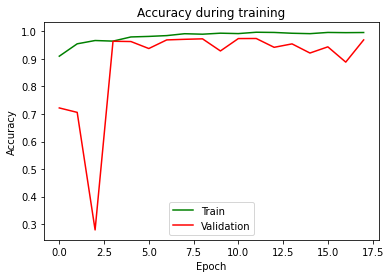

In [12]:
plt.plot(anomalyTraining.history['accuracy'], "green")
plt.plot(anomalyTraining.history['val_accuracy'], "red")
plt.title('Accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower center')
plt.show()

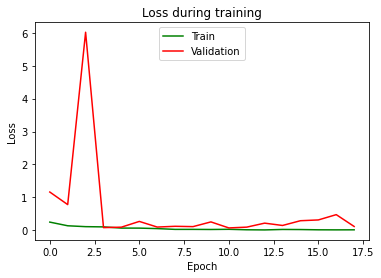

In [13]:
plt.plot(anomalyTraining.history['loss'], "green")
plt.plot(anomalyTraining.history['val_loss'], "red")
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper center')
plt.show()

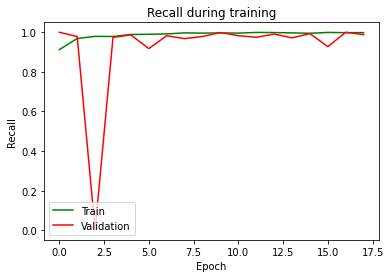

In [14]:
plt.plot(anomalyTraining.history['recall'], "green")
plt.plot(anomalyTraining.history['val_recall'], "red")
plt.title('Recall during training')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower left')
plt.show()

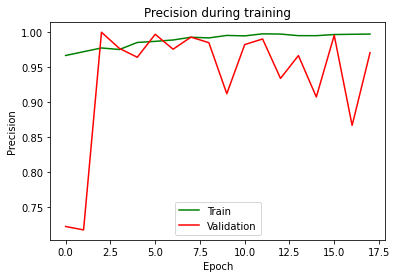

In [15]:
plt.plot(anomalyTraining.history['precision'], "green")
plt.plot(anomalyTraining.history['val_precision'], "red")
plt.title('Precision during training')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower center')
plt.show()